This notebook constructs a more complex model of evolving state number densities for a multiple mass bins.  The method is tested by simulating some data and fitting it, recovering the correct parameters.  The fit may be performed using direct minimization, or MCMC in order to explore the parameter space.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import pickle

In [2]:
# Steven's emcee stuff
import convenience
from convenience import run_emcee
from pdfs import norm_logpdf, beta_logpdf
import plots

In [3]:
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12

In [4]:
C = cosmology.FlatLambdaCDM(70.0, 0.3)

In [5]:
basic_states = ['BD', 'RD', 'RE']
states = []
for i in range(6):
    for s in basic_states:
        states.append('{}{}'.format(s, i))
states.append('NE')
states = pd.Index(states)
nStates = len(states)

In [6]:
states

Index(['BD0', 'RD0', 'RE0', 'BD1', 'RD1', 'RE1', 'BD2', 'RD2', 'RE2', 'BD3',
       'RD3', 'RE3', 'BD4', 'RD4', 'RE4', 'BD5', 'RD5', 'RE5', 'NE'],
      dtype='object')

In [7]:
rate_labels = [['$r_{' + '{} \\rightarrow {}'.format(s2, s1) + '}$' for s2 in states] for s1 in states]
rate_labels = pd.DataFrame(index='to ' + states, columns='from ' + states, data=rate_labels)
rate_evol_labels = rate_labels.replace('\$r', '$\dot{r}', regex=True)
N_labels = '$N_{' + states + '}$'

In [8]:
N_labels

Index(['$N_{BD0}$', '$N_{RD0}$', '$N_{RE0}$', '$N_{BD1}$', '$N_{RD1}$',
       '$N_{RE1}$', '$N_{BD2}$', '$N_{RD2}$', '$N_{RE2}$', '$N_{BD3}$',
       '$N_{RD3}$', '$N_{RE3}$', '$N_{BD4}$', '$N_{RD4}$', '$N_{RE4}$',
       '$N_{BD5}$', '$N_{RD5}$', '$N_{RE5}$', '$N_{NE}$'],
      dtype='object')

In [9]:
rate_labels

,from BD0,from RD0,from RE0,from BD1,from RD1,from RE1,from BD2,from RD2,from RE2,from BD3,from RD3,from RE3,from BD4,from RD4,from RE4,from BD5,from RD5,from RE5,from NE
to BD0,$r_{BD0 \rightarrow BD0}$,$r_{RD0 \rightarrow BD0}$,$r_{RE0 \rightarrow BD0}$,$r_{BD1 \rightarrow BD0}$,$r_{RD1 \rightarrow BD0}$,$r_{RE1 \rightarrow BD0}$,$r_{BD2 \rightarrow BD0}$,$r_{RD2 \rightarrow BD0}$,$r_{RE2 \rightarrow BD0}$,$r_{BD3 \rightarrow BD0}$,$r_{RD3 \rightarrow BD0}$,$r_{RE3 \rightarrow BD0}$,$r_{BD4 \rightarrow BD0}$,$r_{RD4 \rightarrow BD0}$,$r_{RE4 \rightarrow BD0}$,$r_{BD5 \rightarrow BD0}$,$r_{RD5 \rightarrow BD0}$,$r_{RE5 \rightarrow BD0}$,$r_{NE \rightarrow BD0}$
to RD0,$r_{BD0 \rightarrow RD0}$,$r_{RD0 \rightarrow RD0}$,$r_{RE0 \rightarrow RD0}$,$r_{BD1 \rightarrow RD0}$,$r_{RD1 \rightarrow RD0}$,$r_{RE1 \rightarrow RD0}$,$r_{BD2 \rightarrow RD0}$,$r_{RD2 \rightarrow RD0}$,$r_{RE2 \rightarrow RD0}$,$r_{BD3 \rightarrow RD0}$,$r_{RD3 \rightarrow RD0}$,$r_{RE3 \rightarrow RD0}$,$r_{BD4 \rightarrow RD0}$,$r_{RD4 \rightarrow RD0}$,$r_{RE4 \rightarrow RD0}$,$r_{BD5 \rightarrow RD0}$,$r_{RD5 \rightarrow RD0}$,$r_{RE5 \rightarrow RD0}$,$r_{NE \rightarrow RD0}$
to RE0,$r_{BD0 \rightarrow RE0}$,$r_{RD0 \rightarrow RE0}$,$r_{RE0 \rightarrow RE0}$,$r_{BD1 \rightarrow RE0}$,$r_{RD1 \rightarrow RE0}$,$r_{RE1 \rightarrow RE0}$,$r_{BD2 \rightarrow RE0}$,$r_{RD2 \rightarrow RE0}$,$r_{RE2 \rightarrow RE0}$,$r_{BD3 \rightarrow RE0}$,$r_{RD3 \rightarrow RE0}$,$r_{RE3 \rightarrow RE0}$,$r_{BD4 \rightarrow RE0}$,$r_{RD4 \rightarrow RE0}$,$r_{RE4 \rightarrow RE0}$,$r_{BD5 \rightarrow RE0}$,$r_{RD5 \rightarrow RE0}$,$r_{RE5 \rightarrow RE0}$,$r_{NE \rightarrow RE0}$
to BD1,$r_{BD0 \rightarrow BD1}$,$r_{RD0 \rightarrow BD1}$,$r_{RE0 \rightarrow BD1}$,$r_{BD1 \rightarrow BD1}$,$r_{RD1 \rightarrow BD1}$,$r_{RE1 \rightarrow BD1}$,$r_{BD2 \rightarrow BD1}$,$r_{RD2 \rightarrow BD1}$,$r_{RE2 \rightarrow BD1}$,$r_{BD3 \rightarrow BD1}$,$r_{RD3 \rightarrow BD1}$,$r_{RE3 \rightarrow BD1}$,$r_{BD4 \rightarrow BD1}$,$r_{RD4 \rightarrow BD1}$,$r_{RE4 \rightarrow BD1}$,$r_{BD5 \rightarrow BD1}$,$r_{RD5 \rightarrow BD1}$,$r_{RE5 \rightarrow BD1}$,$r_{NE \rightarrow BD1}$
to RD1,$r_{BD0 \rightarrow RD1}$,$r_{RD0 \rightarrow RD1}$,$r_{RE0 \rightarrow RD1}$,$r_{BD1 \rightarrow RD1}$,$r_{RD1 \rightarrow RD1}$,$r_{RE1 \rightarrow RD1}$,$r_{BD2 \rightarrow RD1}$,$r_{RD2 \rightarrow RD1}$,$r_{RE2 \rightarrow RD1}$,$r_{BD3 \rightarrow RD1}$,$r_{RD3 \rightarrow RD1}$,$r_{RE3 \rightarrow RD1}$,$r_{BD4 \rightarrow RD1}$,$r_{RD4 \rightarrow RD1}$,$r_{RE4 \rightarrow RD1}$,$r_{BD5 \rightarrow RD1}$,$r_{RD5 \rightarrow RD1}$,$r_{RE5 \rightarrow RD1}$,$r_{NE \rightarrow RD1}$
to RE1,$r_{BD0 \rightarrow RE1}$,$r_{RD0 \rightarrow RE1}$,$r_{RE0 \rightarrow RE1}$,$r_{BD1 \rightarrow RE1}$,$r_{RD1 \rightarrow RE1}$,$r_{RE1 \rightarrow RE1}$,$r_{BD2 \rightarrow RE1}$,$r_{RD2 \rightarrow RE1}$,$r_{RE2 \rightarrow RE1}$,$r_{BD3 \rightarrow RE1}$,$r_{RD3 \rightarrow RE1}$,$r_{RE3 \rightarrow RE1}$,$r_{BD4 \rightarrow RE1}$,$r_{RD4 \rightarrow RE1}$,$r_{RE4 \rightarrow RE1}$,$r_{BD5 \rightarrow RE1}$,$r_{RD5 \rightarrow RE1}$,$r_{RE5 \rightarrow RE1}$,$r_{NE \rightarrow RE1}$
to BD2,$r_{BD0 \rightarrow BD2}$,$r_{RD0 \rightarrow BD2}$,$r_{RE0 \rightarrow BD2}$,$r_{BD1 \rightarrow BD2}$,$r_{RD1 \rightarrow BD2}$,$r_{RE1 \rightarrow BD2}$,$r_{BD2 \rightarrow BD2}$,$r_{RD2 \rightarrow BD2}$,$r_{RE2 \rightarrow BD2}$,$r_{BD3 \rightarrow BD2}$,$r_{RD3 \rightarrow BD2}$,$r_{RE3 \rightarrow BD2}$,$r_{BD4 \rightarrow BD2}$,$r_{RD4 \rightarrow BD2}$,$r_{RE4 \rightarrow BD2}$,$r_{BD5 \rightarrow BD2}$,$r_{RD5 \rightarrow BD2}$,$r_{RE5 \rightarrow BD2}$,$r_{NE \rightarrow BD2}$
to RD2,$r_{BD0 \rightarrow RD2}$,$r_{RD0 \rightarrow RD2}$,$r_{RE0 \rightarrow RD2}$,$r_{BD1 \rightarrow RD2}$,$r_{RD1 \rightarrow RD2}$,$r_{RE1 \rightarrow RD2}$,$r_{BD2 \rightarrow RD2}$,$r_{RD2 \rightarrow RD2}$,$r_{RE2 \rightarrow RD2}$,$r_{BD3 \rightarrow RD2}$,$r_{RD3 \rightarrow RD2}$,$r_{RE3 \rightarrow RD2}$,$r_{BD4 \r

In [10]:
# Set initial number densities
N0 = pd.Series(index=N_labels, data=np.zeros(nStates))

# Set rates per galaxy in Gyr^{-1} at fiducial redshift
rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((nStates, nStates)))

# Modelling rates as linear function of cosmic time
#(for simplicity, should probably choose someting more appropriate)
rates_evol = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((nStates, nStates)))

# Select which parameters to fit.
fit_N0 = pd.Series(index=N_labels, data=np.zeros(nStates, np.bool))
fit_rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                         data=np.zeros((nStates, nStates), np.bool))
#fit_rates_evol = pd.DataFrame(index='to ' + states, columns='from ' + states,
#                         data=np.zeros((nStates, nStates), np.bool))
fit_rates_evol = None

Basic differential equations:

Blue Disks in stellar mass bin $i \in \{1,2,3,4\}$ may:
* spontaneously form in lowest mass bin, at a total rate $f_{BD_1}$
* transition from the previous mass bin (due to SF and minor mergers), at an individual rate $r_{BD_{i-1} \rightarrow BD_{i}}$
* transition to Red Discs in same mass bin, at an individual rate $r_{BD_{i} \rightarrow RD_{i}}$
* transition to Red Ellipticals in same mass bin, at an individual rate $r_{BD_{i} \rightarrow RE_{i}}$
* transition to the next mass bin (due to SF or minor mergers), at an individual rate $r_{BD_{i} \rightarrow BD_{i+1}}$

For convenience we can define $N_{BD_0} = 1$, such that $r_{BD_0 \rightarrow BD_1} = f_{BD_1}$, the spontaneous formation rate.

$\frac{dN_{BD_{i}}}{dt} = + N_{BD_{i-1}} r_{BD_{i-1} \rightarrow BD_{i}} - N_{BD_{i}} \, (r_{BD_{i} \rightarrow RD_{i}} + r_{BD_{i} \rightarrow RE_{i}} + r_{BD_{i} \rightarrow BD_{i+1}})$

Red Disks in stellar mass bin $i \in \{1,2,3,4\}$ may:
* transition from Blue Discs in same mass bin, at an individual rate $r_{BD_{i} \rightarrow RD_{i}}$
* transition to Red Ellipticals in same mass bin, at an individual rate $r_{D_{i} \rightarrow RE_{i}}$

$\frac{dN_{RD_{i}}}{dt} = - N_{RD_{i}} \, r_{RD_{i} \rightarrow RE_{i}} + N_{BD_{i}} \, r_{BD_{i} \rightarrow RD_{i}}$

Red Ellipticals in stellar mass bin $i \in \{1,2,3,4\}$ may:
* transition from the previous mass bin (due to equal mergers), at an individual rate $r_{RE_{i-1} \rightarrow RE_{i}}$
* transition from Blue Discs in same mass bin, at an individual rate $r_{BD_{i} \rightarrow RE_{i}}$
* transition from Red Discs in same mass bin, at an individual rate $r_{RD_{i} \rightarrow RE_{i}}$
* transition to the next mass bin (due to mergers), at an individual rate $r_{RE_{i} \rightarrow RE_{i+1}}$
* transition to None Existent (due to mergers), at an individual rate $r_{RE_{i} \rightarrow NE}$

Note that $N_{RE_0} = 0$ always.


$\frac{dN_{RE_{i}}}{dt} = + N_{RD_{i}} \, r_{RD_{i} \rightarrow RE_{i}} + N_{BD_{i}} \, r_{BD_{i} \rightarrow RE_{i}} + N_{RE_{i-1}} \, r_{RE_{i-1} \rightarrow RE_{i}} - N_{RE_{i}} ( r_{RE_{i} \rightarrow RE_{i+1}} + r_{RE_{i} \rightarrow NE})$ 

The None Existent state and all mass bins beyond the maximum are equivalent.  They do not contribute to the normalisation of the number densities and do need to be tracked.

All the rates are defined to be positive, they model one-directional flows.

Must be careful about the number density normalisation – for this to make sense it needs to be done across _all_ states, not just within each mass bin.

In [11]:
fit_N0['$N_{BD0}$'] = False
fit_N0['$N_{RD0}$'] = False
fit_N0['$N_{RE0}$'] = False
fit_N0['$N_{BD1}$'] = True
fit_N0['$N_{RD1}$'] = True
fit_N0['$N_{RE1}$'] = True
fit_N0['$N_{BD2}$'] = True
fit_N0['$N_{RD2}$'] = True
fit_N0['$N_{RE2}$'] = True
fit_N0['$N_{BD3}$'] = True
fit_N0['$N_{RD3}$'] = True
fit_N0['$N_{RE3}$'] = True
fit_N0['$N_{BD4}$'] = True
fit_N0['$N_{RD4}$'] = True
fit_N0['$N_{RE4}$'] = True
fit_N0['$N_{BD5}$'] = False
fit_N0['$N_{RD5}$'] = False
fit_N0['$N_{RE5}$'] = False
fit_N0['$N_{NE}$']  = False

N0['$N_{BD0}$'] = 0
N0['$N_{RD0}$'] = 0
N0['$N_{RE0}$'] = 0
N0['$N_{BD1}$'] = 0.7
N0['$N_{RD1}$'] = 0.1
N0['$N_{RE1}$'] = 0.2
N0['$N_{BD2}$'] = 0.6
N0['$N_{RD2}$'] = 0.1
N0['$N_{RE2}$'] = 0.3
N0['$N_{BD3}$'] = 0.5
N0['$N_{RD3}$'] = 0.2
N0['$N_{RE3}$'] = 0.3
N0['$N_{BD4}$'] = 0.4
N0['$N_{RD4}$'] = 0.2
N0['$N_{RE4}$'] = 0.4
N0['$N_{BD5}$'] = 0
N0['$N_{RD5}$'] = 0
N0['$N_{RE5}$'] = 0
N0['$N_{NE}$']  = 0

N0 /= N0.values.sum()
N0['$N_{BD0}$'] = 1
N0

$N_{BD0}$    1.000
$N_{RD0}$    0.000
$N_{RE0}$    0.000
$N_{BD1}$    0.175
$N_{RD1}$    0.025
$N_{RE1}$    0.050
$N_{BD2}$    0.150
$N_{RD2}$    0.025
$N_{RE2}$    0.075
$N_{BD3}$    0.125
$N_{RD3}$    0.050
$N_{RE3}$    0.075
$N_{BD4}$    0.100
$N_{RD4}$    0.050
$N_{RE4}$    0.100
$N_{BD5}$    0.000
$N_{RD5}$    0.000
$N_{RE5}$    0.000
$N_{NE}$     0.000
dtype: float64

In [12]:
for i in range(5):
    fit_rates['from BD{}'.format(i)]['to BD{}'.format(i+1)] = True

for i in range(1, 5):
    fit_rates['from BD{}'.format(i)]['to RD{}'.format(i)] = True
    fit_rates['from BD{}'.format(i)]['to RE{}'.format(i)] = True
    fit_rates['from RD{}'.format(i)]['to RE{}'.format(i)] = True
    fit_rates['from RE{}'.format(i)]['to NE'] = True

for i in range(1, 5):
    fit_rates['from RE{}'.format(i)]['to RE{}'.format(i+1)] = True

In [13]:
fit_rates

,from BD0,from RD0,from RE0,from BD1,from RD1,from RE1,from BD2,from RD2,from RE2,from BD3,from RD3,from RE3,from BD4,from RD4,from RE4,from BD5,from RD5,from RE5,from NE
to BD0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
to RD0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
to RE0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
to BD1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
to RD1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
to RE1,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
to BD2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
to RD2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
to RE2,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
to BD3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
def rates_function(rates, rates_evol, t, t0):
    # this used to take pandas DataFrames, but now requires numpy arrays for efficiency
    # shortcut if no evolution
    if rates_evol is None:
        return rates
    rates = rates + rates_evol * (t - t0)
    # ensure rates are valid and sensible
    rates = np.clip(rates, 0, 1)
    # * For a closed model the columns of the rates matrix must sum to zero
    #   so there is no creation/destruction of galaxies, this is enforced here.
    # * Creation/destruction of galaxies basically means they move in to or
    #   out of the sample given the selection criteria.
    # * Another possibility is merging, where one galaxies is 'destroyed' in
    #   each merger.
    # * If one wishes to create/destroy galaxies then that could perhaps
    #   be achieved by allowing rates to not sum to zero in each column.
    #   However, the total numbers of galaxies moving between states are
    #   proportional to the number currently in the initial state, which
    #   probably doesn't make much sense for creation.
    #   Alternatively, one could add an additional state(s) representing the pool(s)
    #   from which galaxies are created/destroyed (but this would be evolved itself).
    #   Or one could add additional terms in the differential equation to
    #   describe the creation/destruction of galaxies.
    # * Another issue is multiple selection criteria, e.g. mass bins.
    #   These are essentially different states, and we can model transitions
    #   between them in the same manner: in a small time a galaxy in a given state
    #   will have a particular (potentially time dependent) probability of moving
    #   from one mass bin to the next
    #   (proportional to [SFR + merger accretion rate] / mass_bin_width).
    # * In principle, the rates related to the destruction of galaxies in particular
    #   states due to merging and the mass growth of the merger remnant are related.
    #   In practise this would be pretty complex to manage unless we make some
    #   strict assumptions.  For example, we could assume that only galaxies in the
    #   same state merge (hence ~doubling their mass) and thus require the
    #   destruction rate to be proportional to the mass bin transition rate
    #   (where the factor depends on the width of the mass bin).
    #   If we get too complicated, then it would make more sense to simulate a large
    #   population of individual galaxies rather than consider a small set of states.
    di = np.diag_indices(len(rates))
    rates[di] = 0
    from_sum = rates.sum(0)
    rates[di] = -from_sum
    rates[0, 0] = 0  # no changes to BD0
    return rates

In [15]:
def model(N, t, ratefn, rates, rates_evol, t0):
    rates = ratefn(rates, rates_evol, t, t0)
    return np.dot(rates, N)

In [16]:
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle, encoding='latin1')

In [17]:
mdata = results['m_centers'][1:]
zdata = results['z_centers']
tdata = C.age(zdata)
z0 = 1.0
t0 = C.age(z0).value

In [18]:
Ndata = pd.DataFrame(index=zdata, columns=N_labels, data=np.zeros((len(zdata), nStates)))
for i in range(1, 5):
    mresults = results['M={:.2f}'.format(mdata[i-1])]
    for key, value in mresults.items():
        if key.startswith('N'):
            state = '{}{}'.format(key[2:], i)
            Ndata['$N_{' + state + '}$'] = value
Ndata = Ndata[::-1]
zdata = zdata[::-1]
tdata = tdata[::-1]
nGal = Ndata.sum(1)

In [19]:
Ndata

,$N_{BD0}$,$N_{RD0}$,$N_{RE0}$,$N_{BD1}$,$N_{RD1}$,$N_{RE1}$,$N_{BD2}$,$N_{RD2}$,$N_{RE2}$,$N_{BD3}$,$N_{RD3}$,$N_{RE3}$,$N_{BD4}$,$N_{RD4}$,$N_{RE4}$,$N_{BD5}$,$N_{RD5}$,$N_{RE5}$,$N_{NE}$
0.99,0.0,0.0,0.0,1164.077179,8.774451,225.225549,985.663340,70.195609,514.804391,643.459747,128.691949,587.308051,266.158350,114.067864,310.932136,0.0,0.0,0.0,0.0
0.76,0.0,0.0,0.0,1071.881221,33.094103,579.905897,919.280636,101.120870,836.879130,643.496445,141.569218,750.430782,253.721455,99.282309,365.717691,0.0,0.0,0.0,0.0
0.54,0.0,0.0,0.0,533.579750,24.131747,285.868253,474.591034,48.263495,303.736505,336.503812,44.241537,200.758463,119.318085,34.856969,124.143031,0.0,0.0,0.0,0.0
0.31,0.0,0.0,0.0,382.000000,57.000000,243.000000,337.000000,67.000000,237.000000,214.000000,42.000000,167.000000,69.000000,20.000000,106.000000,0.0,0.0,0.0,0.0


In [20]:
# strip off unmeasured quantitites
Ndata = Ndata.filter(regex='.*[1234].*')

In [21]:
Nerr = np.sqrt(Ndata)
Ndata = (Ndata.T / nGal).T
Nerr = (Nerr.T / nGal).T

In [22]:
Ndata

,$N_{BD1}$,$N_{RD1}$,$N_{RE1}$,$N_{BD2}$,$N_{RD2}$,$N_{RE2}$,$N_{BD3}$,$N_{RD3}$,$N_{RE3}$,$N_{BD4}$,$N_{RD4}$,$N_{RE4}$
0.99,0.231918,0.001748,0.044871,0.196372,0.013985,0.102564,0.128196,0.025639,0.117009,0.053026,0.022726,0.061947
0.76,0.184923,0.005709,0.100046,0.158596,0.017446,0.144380,0.111017,0.024424,0.129465,0.043772,0.017128,0.063094
0.54,0.210902,0.009538,0.112992,0.187586,0.019077,0.120054,0.133006,0.017487,0.079351,0.047161,0.013777,0.049069
0.31,0.196806,0.029366,0.125193,0.173622,0.034518,0.122102,0.110252,0.021638,0.086038,0.035549,0.010304,0.054611


In [23]:
Nerr

,$N_{BD1}$,$N_{RD1}$,$N_{RE1}$,$N_{BD2}$,$N_{RD2}$,$N_{RE2}$,$N_{BD3}$,$N_{RD3}$,$N_{RE3}$,$N_{BD4}$,$N_{RD4}$,$N_{RE4}$
0.99,0.006797,0.000590,0.002990,0.006255,0.001669,0.004520,0.005054,0.002260,0.004828,0.003250,0.002128,0.003513
0.76,0.005648,0.000992,0.004155,0.005231,0.001735,0.004991,0.004376,0.002053,0.004726,0.002748,0.001719,0.003299
0.54,0.009130,0.001942,0.006683,0.008611,0.002746,0.006889,0.007251,0.002629,0.005600,0.004318,0.002334,0.004404
0.31,0.010069,0.003890,0.008031,0.009458,0.004217,0.007931,0.007537,0.003339,0.006658,0.004280,0.002304,0.005304


In [24]:
def calc_F(N, Nerr=None):
    F = pd.DataFrame(index=N.index)
    if Nerr is not None:
        Ferr = pd.DataFrame(index=N.index)
    for i in range(1, 5):
        m = str(i)
        F['$f_{R|D,' + m + '}$'] = N['$N_{RD' + m + '}$'] / (N['$N_{RD' + m + '}$'] + N['$N_{BD' + m + '}$'])
        F['$f_{D|R,' + m + '}$'] = N['$N_{RD' + m + '}$'] / (N['$N_{RD' + m + '}$'] + N['$N_{RE' + m + '}$'])
        if Nerr is not None:
            NDsum = N['$N_{RD' + m + '}$'] + N['$N_{BD' + m + '}$']
            dfRDdNRD = 1 / NDsum - N['$N_{RD' + m + '}$'] / NDsum**2
            dfRDdNBD = - N['$N_{RD' + m + '}$'] / NDsum**2
            Ferr['$f_{R|D,' + m + '}$'] = np.sqrt(dfRDdNRD**2 * Nerr['$N_{RD' + m + '}$']**2 + 
                                                  dfRDdNBD**2 * Nerr['$N_{BD' + m + '}$']**2)
            NRsum = N['$N_{RD' + m + '}$'] + N['$N_{RE' + m + '}$']
            dfRDdNRD = 1 / NRsum - N['$N_{RD' + m + '}$'] / NRsum**2
            dfRDdNRE = - N['$N_{RD' + m + '}$'] / NRsum**2
            Ferr['$f_{D|R,' + m + '}$'] = np.sqrt(dfRDdNRD**2 * Nerr['$N_{RD' + m + '}$']**2 + 
                                                  dfRDdNRE**2 * Nerr['$N_{RE' + m + '}$']**2)
    if Nerr is not None:
        return F, Ferr
    else:
        return F

In [25]:
Fdata, Ferr = calc_F(Ndata, Nerr)

In [26]:
Fdata

,"$f_{R|D,1}$","$f_{D|R,1}$","$f_{R|D,2}$","$f_{D|R,2}$","$f_{R|D,3}$","$f_{D|R,3}$","$f_{R|D,4}$","$f_{D|R,4}$"
0.99,0.007481,0.037498,0.066482,0.119992,0.166667,0.179737,0.300000,0.268395
0.76,0.029950,0.053987,0.099099,0.107805,0.180328,0.158710,0.281250,0.213510
0.54,0.043269,0.077844,0.092308,0.137112,0.116197,0.180578,0.226087,0.219226
0.31,0.129841,0.190000,0.165842,0.220395,0.164063,0.200957,0.224719,0.158730


In [27]:
Ferr

,"$f_{R|D,1}$","$f_{D|R,1}$","$f_{R|D,2}$","$f_{D|R,2}$","$f_{R|D,3}$","$f_{D|R,3}$","$f_{R|D,4}$","$f_{D|R,4}$"
0.99,0.002516,0.012419,0.007667,0.013435,0.013412,0.014350,0.023501,0.021495
0.76,0.005128,0.009128,0.009354,0.010126,0.013721,0.012235,0.023930,0.019003
0.54,0.008615,0.015217,0.012659,0.018333,0.016423,0.024576,0.033688,0.032810
0.31,0.016043,0.022650,0.018505,0.023774,0.023146,0.027718,0.044244,0.032555


In [28]:
def plot_N(N, Nerr, Nfit=None):
    fig, axarr = plt.subplots(2, 2, figsize=(12, 10))
    axarr = axarr.flat
    for i in range(4):
        Nm = N.filter(regex=('.*{}.*'.format(i+1)))
        Nerrm = Nerr.filter(regex=('.*{}.*'.format(i+1)))
        if Nfit is not None:
            Nfitm = Nfit.filter(regex=('.*{}.*'.format(i+1)))
        for j, col in enumerate(Nm):
            axarr[i].errorbar(Nm.index, Nm[col], Nerrm[col], label=col, color='C{}'.format(j))
            if Nfit is not None:
                axarr[i].plot(Nfitm.index, Nfitm[col], '--', color='C{}'.format(j))
        axarr[i].set(xlabel='$z$', ylabel='$N(z)/N(z={:.1f})$'.format(z0),
                  ylim=(0, 0.35), title='$\log(M/M_\odot) \sim {}$'.format(mdata[i]))
        handles, labels = axarr[i].get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        axarr[i].legend(handles, labels, loc=1, ncol=3)
    plt.tight_layout()

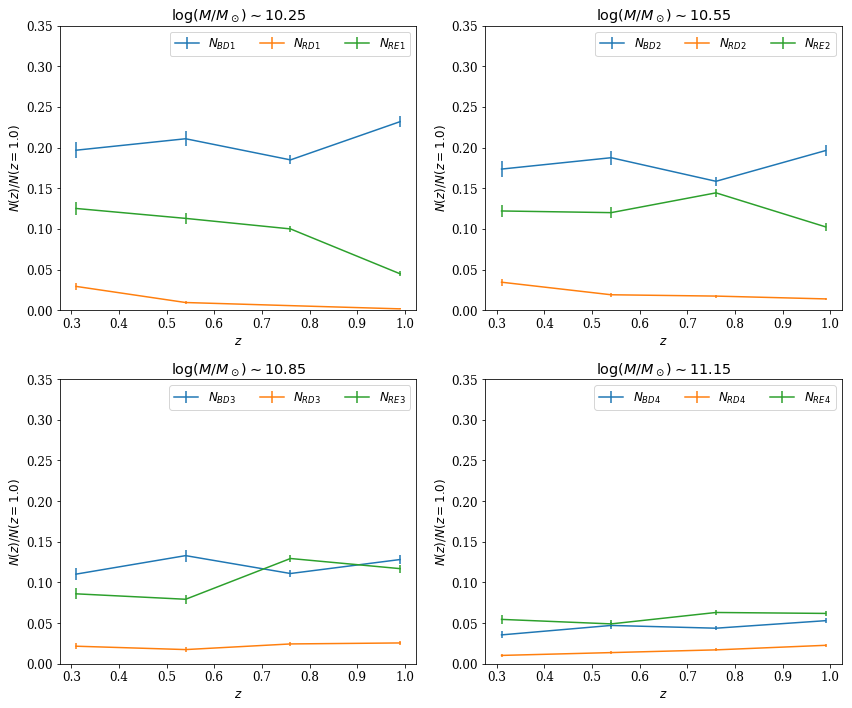

In [29]:
plot_N(Ndata, Nerr)

In [30]:
def plot_F(F, Ferr, Ffit=None):
    fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    axarr = axarr.flat
    Fm = F.filter(regex=('.*R.D,[1234].*'))
    Ferrm = Ferr.filter(regex=('.*R.D,[1234].*'))
    if Ffit is not None:
        Ffitm = Ffit.filter(regex=('.*R.D,[1234].*'))        
    for j, col in enumerate(Fm):
        axarr[0].errorbar(Fm.index, Fm[col], Ferrm[col], label=col, color='C{}'.format(j))
        if Ffit is not None:
            axarr[0].plot(Ffitm.index, Ffitm[col], '--', color='C{}'.format(j))
    axarr[0].set(xlabel='$z$', ylabel='$f_{R|D}(z)$',
              ylim=(0, 0.4))
    handles, labels = axarr[0].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    axarr[0].legend(handles, labels, loc=1, ncol=4)
    Fm = F.filter(regex=('.*D.R,[1234].*'))
    Ferrm = Ferr.filter(regex=('.*D.R,[1234].*'))
    if Ffit is not None:
        Ffitm = Ffit.filter(regex=('.*D.R,[1234].*'))        
    for j, col in enumerate(Fm):
        axarr[1].errorbar(Fm.index, Fm[col], Ferrm[col], label=col, color='C{}'.format(j))
        if Ffit is not None:
            axarr[1].plot(Ffitm.index, Ffitm[col], '--', color='C{}'.format(j))
    axarr[1].set(xlabel='$z$', ylabel='$f_{D|R}(z)$',
              ylim=(0, 0.4))
    handles, labels = axarr[1].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    axarr[1].legend(handles, labels, loc=1, ncol=4)
    plt.tight_layout()

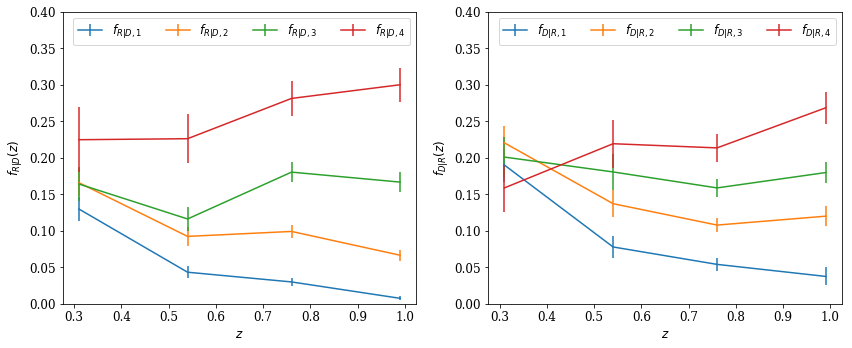

In [31]:
plot_F(Fdata, Ferr)

In [32]:
class logProbabilities:
    def __init__(self, fit_N0, fit_rates, fit_rates_evol, Nmask,
                 Ndata, Nerr, tdata, ratefn, N0_init, rates_init, rates_evol_init,
                 t0, N_labels, rate_labels, rate_evol_labels):
        # a boolean matrix describing which rates and evolutions to fit
        self.fit_N0 = fit_N0.copy()
        self.nFitN0 = self.fit_N0.values.sum()
        self.fit_rates = fit_rates.copy()
        self.nStates = len(fit_rates)
        self.nFitRates = self.fit_rates.values.sum()
        if rates_evol_init is not None:
            self.fit_rates_evol = fit_rates_evol.copy()
            self.nFitRatesEvol = self.fit_rates_evol.values.sum()
        else:
            self.fit_rates_evol = None
            self.nFitRatesEvol = 0
        self.pars = []
        self.pars.extend(N_labels.values[self.fit_N0.values])
        self.pars.extend(rate_labels.values[self.fit_rates.values])
        if rates_evol_init is not None:
            self.pars.extend(rate_evol_labels.values[self.fit_rates_evol.values])
        self.pars = pd.DataFrame(self.pars, columns=['parameter'])
        self.nPar = self.nFitN0 + self.nFitRates + self.nFitRatesEvol
        # the measured number density, Ndata,
        # in each state at time, tdata,
        # with its error, Nerr
        self.Ndata = Ndata.copy()
        self.Nerr = Nerr.copy()        
        self.tdata = tdata.copy()
        # the current rate matrix is determined using ratefn
        # from N0, the number densities at t0; rates, the rates at t0; and rates_evol
        self.ratefn = ratefn
        self.N0 = N0_init.copy()
        self.rates = rates_init.copy()
        if rates_evol_init is not None:
            self.rates_evol = rates_evol_init.copy()
        else:
            self.rates_evol = None
        self.t0 = t0
        # Which states are actually measured
        self.Nmask = Nmask

    def split_pars(self, p):
        start, end = (0, self.nFitN0)
        p_N0 = p[start:end]
        start, end = (end, end + self.nFitRates)
        p_rates = p[start:end]
        start, end = (end, end + self.nFitRatesEvol)
        p_rates_evol = p[start:end]
        return p_N0, p_rates, p_rates_evol
        
    def evaluate(self, t, p, strip=True):
        # update the model quantities given the current parameters
        p_N0, p_rates, p_rates_evol = self.split_pars(p)
        self.N0.values[self.fit_N0.values] = p_N0
        self.rates.values[self.fit_rates.values] = p_rates
        if self.rates_evol is not None:
            self.rates_evol.values[self.fit_rates_evol.values] = p_rates_evol
        # compute N at each tdata, given current parameters
        N0 = self.N0.values
        rates = self.rates.values    
        if self.rates_evol is None:
            rates_evol = None
        else:
            rates_evol = self.rates_evol.values
        N = odeint(model, N0, t,
                   args=(self.ratefn, rates, rates_evol, self.t0))
        if strip:
            # strip off unmeasured quantitites
            N = N[:, self.Nmask]
            # convert to normalised relative densities at each redshift
            N = (N.T / N.sum(1)).T
        return N
    
    def prior(self, inpars):
        inshape = inpars.shape
        inpars = inpars.reshape((-1, self.nPar))
        lnP = np.zeros(inpars.shape[0])
        for i, p in enumerate(inpars):
            p_N0, p_rates, p_rates_evol = self.split_pars(p)
            lnP[i] = stats.uniform(0, 1).logpdf(p_N0).sum()
            lnP[i] += stats.uniform(0, 1).logpdf(p_rates).sum()
            lnP[i] += norm_logpdf(p_rates_evol, 0, 0.1).sum()
        return lnP.reshape(inshape[:-1])
    
    def likelihood(self, inpars):
        inshape = inpars.shape
        inpars = inpars.reshape((-1, self.nPar))
        lnL = np.zeros(inpars.shape[0])
        for i, p in enumerate(inpars):
            N = self.evaluate(self.tdata, p)
            # calculate Likelihood of computed N given Ndata and Nerr
            lnL[i] = norm_logpdf(N, self.Ndata.values, self.Nerr.values).sum()
        return lnL.reshape(inshape[:-1])
    
    def posterior(self, inpars):
        lnL = self.likelihood(inpars)
        lnP = self.prior(inpars)
        return lnL + lnP
    
    def neg_posterior(self, inpars):
        return -self.posterior(inpars)
    
    def init_pars(self, shape):
        ip = np.zeros(shape + (self.nPar,))
        start, end = (0, self.nFitN0)
        ip[..., start:end] = stats.uniform.rvs(0, 1, size=shape + (self.nFitN0,))
        start, end = (end, end + self.nFitRates)
        ip[..., start:end] = stats.uniform.rvs(0, 1, size=shape + (self.nFitRates,))
        start, end = (end, end + self.nFitRatesEvol)
        ip[..., start:end] = stats.norm.rvs(0, 0.1, size=shape + (self.nFitRatesEvol,))
        return ip

In [33]:
# Define initial values.
# Those to be fit will vary.
# The rest will be held fixed at their initial values.
N0_init = pd.Series(index=N_labels, data=N0, name=False)
rates_init = pd.DataFrame(index='to ' + states, columns='from ' + states,
                          data=np.zeros((nStates, nStates)))
#rates_evol_init = pd.DataFrame(index='to ' + states, columns='from ' + states,
#                               data=np.zeros((nStates, nStates)))
rates_evol_init = None

In [34]:
N0_init

$N_{BD0}$    1.000
$N_{RD0}$    0.000
$N_{RE0}$    0.000
$N_{BD1}$    0.175
$N_{RD1}$    0.025
$N_{RE1}$    0.050
$N_{BD2}$    0.150
$N_{RD2}$    0.025
$N_{RE2}$    0.075
$N_{BD3}$    0.125
$N_{RD3}$    0.050
$N_{RE3}$    0.075
$N_{BD4}$    0.100
$N_{RD4}$    0.050
$N_{RE4}$    0.100
$N_{BD5}$    0.000
$N_{RD5}$    0.000
$N_{RE5}$    0.000
$N_{NE}$     0.000
dtype: float64

In [35]:
rates_init

,from BD0,from RD0,from RE0,from BD1,from RD1,from RE1,from BD2,from RD2,from RE2,from BD3,from RD3,from RE3,from BD4,from RD4,from RE4,from BD5,from RD5,from RE5,from NE
to BD0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to RD0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to RE0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to BD1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to RD1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to RE1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to BD2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to RD2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to RE2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
to BD3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
rates_evol_init

In [37]:
Nmask = np.array(['1' in l or '2' in l or '3' in l or '4' in l for l in N_labels])

In [38]:
logProb = logProbabilities(fit_N0, fit_rates, fit_rates_evol, Nmask, Ndata, Nerr, tdata,
                           rates_function, N0_init, rates_init, rates_evol_init,
                           t0, N_labels, rate_labels, rate_evol_labels)

In [39]:
logProb.pars

,parameter
0,$N_{BD1}$
1,$N_{RD1}$
2,$N_{RE1}$
3,$N_{BD2}$
4,$N_{RD2}$
5,$N_{RE2}$
6,$N_{BD3}$
7,$N_{RD3}$
8,$N_{RE3}$
9,$N_{BD4}$


In [40]:
logProb.posterior(logProb.init_pars((5,)))

array([-19544.92526863, -11586.34325048, -22023.27090259, -18024.22870547,
       -24878.63024874])

In [41]:
start = logProb.init_pars((1,))[0]
start[:12] = Ndata.values[0]
start[12:] = 0.00

In [42]:
logProb.posterior(np.array(start))

-240.34425755350938

In [43]:
result = scipy.optimize.minimize(logProb.neg_posterior, start, tol=1e-4, method='Nelder-Mead')
result

 final_simplex: (array([[ 0.35905002,  0.00450597,  0.13874082, ...,  0.00539485,
         0.01050442,  0.0021366 ],
       [ 0.35802837,  0.00447576,  0.13860028, ...,  0.00542668,
         0.01055035,  0.00215857],
       [ 0.35243641,  0.00439799,  0.13619249, ...,  0.00541289,
         0.01047554,  0.00217992],
       ..., 
       [ 0.30046624,  0.00381867,  0.1158881 , ...,  0.00499166,
         0.00934411,  0.00221182],
       [ 0.30270673,  0.00376872,  0.11657825, ...,  0.00490927,
         0.00921353,  0.00216191],
       [ 0.29688089,  0.0037964 ,  0.11436741, ...,  0.00490148,
         0.00916588,  0.00218109]]), array([-12.46730947, -12.22282325, -12.12467921, -11.86635267,
       -11.77970747, -11.67460017, -11.45860425, -11.43927765,
       -11.43295353, -11.37880591, -11.27459319, -11.07978668,
       -10.8655165 , -10.80011219, -10.45648163, -10.4194787 ,
       -10.34938114, -10.18552005, -10.00406145,  -9.88414976,
        -9.82166852,  -9.70921493,  -9.57295138,  -9.

In [44]:
Nfit = Ndata.copy()
Nfit[:] = logProb.evaluate(tdata, result.x)

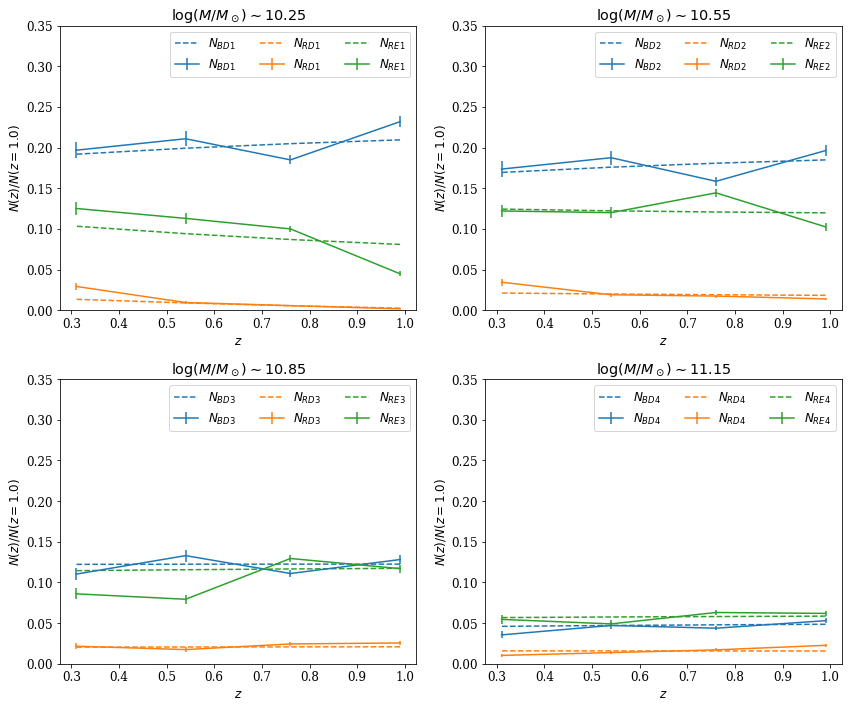

In [45]:
plot_N(Ndata, Nerr, Nfit)

In [46]:
Ffit = calc_F(Nfit)

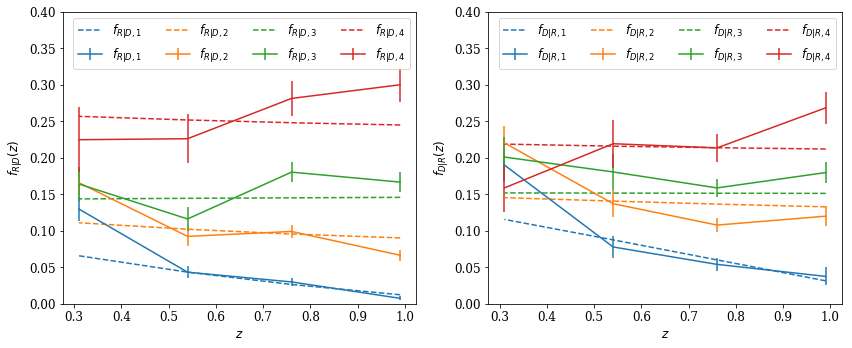

In [47]:
plot_F(Fdata, Ferr, Ffit)

In [48]:
sampler = run_emcee(logProb.likelihood, logProb.prior, logProb.init_pars,
                    ntemps=3, nwalkers=100, nsamples=1500,
                    minlogbeta=None, nupdates=150, threads=1,
                    outfilename='mel_bins_data', saveall=True)

Steps: 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500
Time taken = 1057.66 secs


In [49]:
statistics = plots.print_emcee(sampler, logProb.pars['parameter'], nburn=750,
                               outfilename='mel_bins_data')

$N_{BD1}$        =     0.41 +- 0.08    
$N_{RD1}$        =    0.017 +- 0.004   
$N_{RE1}$        =     0.28 +- 0.08    
$N_{BD2}$        =     0.54 +- 0.06    
$N_{RD2}$        =     0.06 +- 0.02    
$N_{RE2}$        =      0.6 +- 0.1     
$N_{BD3}$        =      0.7 +- 0.2     
$N_{RD3}$        =     0.21 +- 0.07    
$N_{RE3}$        =     0.53 +- 0.10    
$N_{BD4}$        =     0.28 +- 0.07    
$N_{RD4}$        =     0.08 +- 0.03    
$N_{RE4}$        =     0.28 +- 0.06    
$r_{BD0 \rightarrow BD1}$ =     0.86 +- 0.08    
$r_{BD1 \rightarrow RD1}$ =     0.05 +- 0.01    
$r_{BD1 \rightarrow RE1}$ =     0.54 +- 0.05    
$r_{RD1 \rightarrow RE1}$ =     0.16 +- 0.09    
$r_{BD1 \rightarrow BD2}$ =     0.32 +- 0.04    
$r_{BD2 \rightarrow RD2}$ =     0.14 +- 0.03    
$r_{RE1 \rightarrow RE2}$ =      0.3 +- 0.1     
$r_{BD2 \rightarrow RE2}$ =      0.3 +- 0.1     
$r_{RD2 \rightarrow RE2}$ =     0.34 +- 0.09    
$r_{BD2 \rightarrow BD3}$ =     0.21 +- 0.05    
$r_{BD3 \rightarrow RD3}$ =   

In [50]:
Nfit = Ndata.copy()
Nfit[:] = logProb.evaluate(tdata, statistics['maxprob'])

In [51]:
Nfit

,$N_{BD1}$,$N_{RD1}$,$N_{RE1}$,$N_{BD2}$,$N_{RD2}$,$N_{RE2}$,$N_{BD3}$,$N_{RD3}$,$N_{RE3}$,$N_{BD4}$,$N_{RD4}$,$N_{RE4}$
0.99,0.141177,0.003050,0.057402,0.186176,0.014917,0.119872,0.139484,0.036704,0.147662,0.067852,0.016615,0.069088
0.76,0.234933,0.008438,0.107556,0.132577,0.023057,0.127982,0.087090,0.025109,0.108348,0.051323,0.017663,0.075923
0.54,0.196399,0.012628,0.152936,0.124073,0.027960,0.159978,0.067320,0.019122,0.099103,0.041765,0.018009,0.080706
0.31,0.127394,0.013396,0.162762,0.111192,0.032831,0.206559,0.062267,0.016818,0.115334,0.038477,0.018879,0.094092


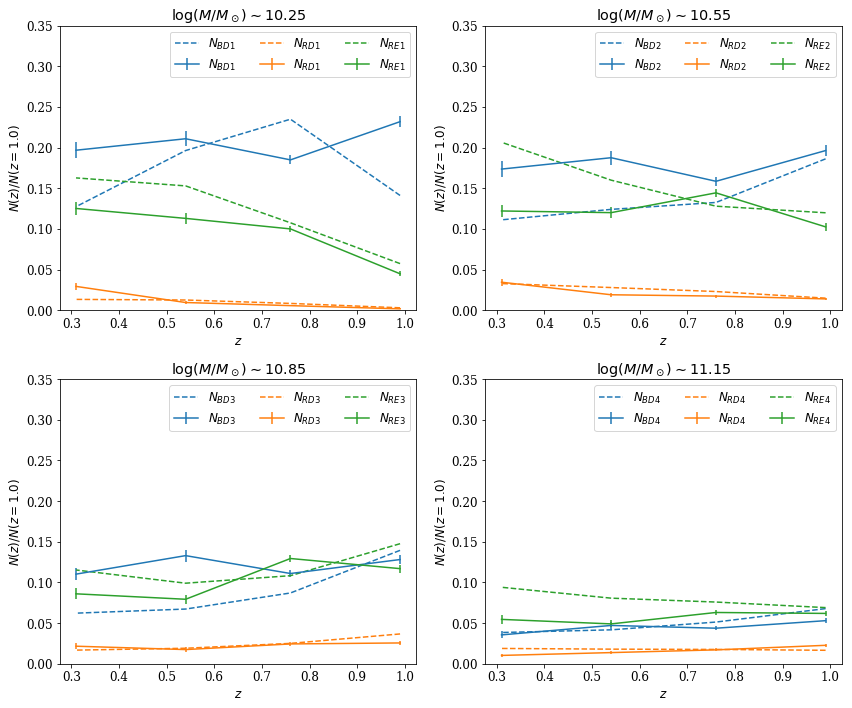

In [52]:
plot_N(Ndata, Nerr, Nfit)

In [53]:
Ffit = calc_F(Nfit)

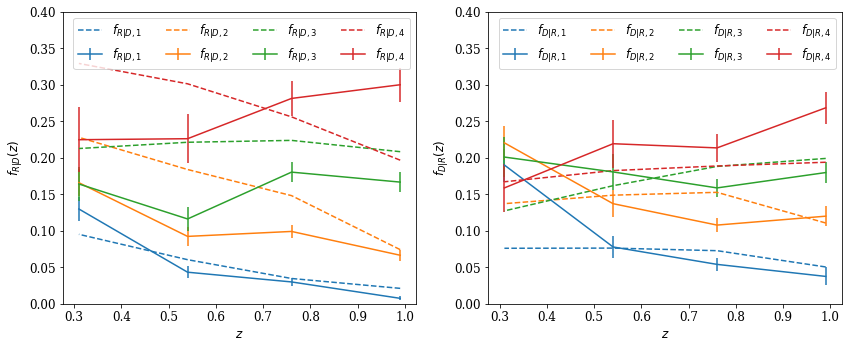

In [54]:
plot_F(Fdata, Ferr, Ffit)

In [ ]:
sampler_long = run_emcee(logProb.likelihood, logProb.prior, logProb.init_pars,
                    ntemps=5, nwalkers=100, nsamples=10000,
                    minlogbeta=None, nupdates=1000, threads=1,
                    outfilename='mel_bins_data_long', saveall=True)

Steps: 10 20 30 40 50 60

In [ ]:
statistics = plots.print_emcee(sampler, logProb.pars['parameter'], nburn=5000,
                               outfilename='mel_bins_data')